# Development of geospatial aap module

This is the first notebook in which I'm just collecting ideas and trying things out for eventual use in the aap geospatial module.

## Potential case: Land use analysis of OU campus

What if we did an analysis of land use on the OU campus?

Could get both RGB imagery as well as computing NDVI. The Carpentries course,
https://carpentries-incubator.github.io/geospatial-python/09-raster-calculations.html, does
NDVI computations and then creates a classification scheme to create a discrete raster from
the continuous NDVI raster. All quite relevant. Sections before this one do typical 
raster and vector operations such as cropping, reprojecting and matching different layers.

- green space
- golf courses
- roads
- buildings
- parking lots
- sports facilities
- sidewalks

Could look at how things have changed over time.

Would require combo of raster and vector data.

- single and multi-band rasters
- missing data in rasters
- cropping rasters

Where to get the vector data? What kind of vector data exists for the OU campus?

How to do the land use analysis?

## Finding data

Need raster and vector data. 

### Raster data

Could use Landsat satellite imagery as it goes back several decades.
Could also use recent Sentinel data to serve as a comparison to Landsat in terms of resolution.

Is there freely available aerial imagery?

Have the DEM from HydroRivers already downloaded.

### Vector data

Open Street Map is one obvious source.

What's available at Open Earth?

State of Michigan or Oakland County?

## Planetary Computer

Acquiring LANDSAT images tutorial - https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2#Example-Notebook

- contains great example of searching for images, narrowing the search, downloading multiple bands, viewing the true color image and doing an NDVI calculation
- use Level-2 only (no blue band in Level 1)

Has tutorial on land classification - https://planetarycomputer.microsoft.com/docs/tutorials/landcover/

- more advanced. Uses DASK cluster and a neural net (via PyTorch) to classify land cover.
- let's look for a precomputed land cover dataset

Microsoft Buildings - https://planetarycomputer.microsoft.com/dataset/ms-buildings

- This dataset contains vector data on buildings. 
- Stage 1: Semantic Segmentation
- Stage 2: Polygonization
- see the example notebook for finding, downloading and viewing with GeoPandas
- data is in geoparquet format

## National Land Cover Database

> The National Land Cover Database (NLCD) provides nationwide data on land cover and land cover change at a 30m resolution with a 16-class legend based on a modified Anderson Level II classification system. NLCD 2021 represents the latest evolution of NLCD land cover products focused on providing innovative land cover and land cover change data for the Nation. NLCD 2021 offers 9 integrated epochs of land cover for years 2001, 2004, 2006, 2008, 2011, 2013, 2016, 2019, and 2021. chs (2001 – 2021) and are directly comparable across the full time series and suitable for multi-temporal analysis. The NLCD 2021 release is update based, so the Land Cover and Impervious Surface products released in 2019 are unchanged and can be used directly with NLCD 2021. Science products and the change index will need to be reacquired to contain the additional 2021 change. Specific map products include:Developed classes in these years are directly derived from percent developed impervious surface and include a descriptor label that identifies the type of each impervious surface pixel. The NLCD Land Cover change index combines information from all years of land cover change and provides a simple and comprehensive way to visualize change from all 9 dates of land cover in a single layer. The change index was designed to assist NLCD users to understand complex land cover change with a single product. NLCD 2021 does not yet contain updated products for Alaska, Hawaii and Puerto Rico. 

In addition to land use rasters, there are also imperviousness rasters (binary?).

https://www.mrlc.gov/data/nlcd-land-cover-conus-all-years

https://www.mrlc.gov/data?f%5B0%5D=category%3ALand%20Cover&f%5B1%5D=region%3Aconus - All years. big file. Download at night.

Most recent update - https://www.sciencebase.gov/catalog/item/5f21cef582cef313ed940043

- this 2019 update seems to be a big one in terms of methodology.

Downloaded just the most recent, 2021, so could get a sense of the data.

The format is something I haven't seen before:

```
├── nlcd_2021_land_cover_l48_20230630.ige
├── nlcd_2021_land_cover_l48_20230630.img
└── nlcd_2021_land_cover_l48_20230630.xml
```

https://gis.stackexchange.com/questions/260728/national-land-cover-dataset-usa-data-extraction

```
gdal_translate -of GTiff  nlcd_2021_land_cover_l48_20230630.img nlcd_2021_land_cover_l48_20230630.tif
```

Cropped it to a bbox I made with OpenStreetMap and manual panning/zooming followed by Export.

```
gdal_translate -of GTiff -projwin -83.2656 42.6974 -83.1369 42.6398 -projwin_srs epsg:4326 nlcd_2021_land_cover_l48_20230630.tif ou.tif
```

Then I downloaded the whole thing - one file per year is included in the zip file. So we need to crop individually. Wait, maybe not - looks like there might be a combined file. The combined filename has "change_index" in its name. Let's explore both.

```
gdal_translate -of GTiff -projwin -83.2656 42.6974 -83.1369 42.6398 -projwin_srs epsg:4326 nlcd_2001_2021_land_cover_change_index_l48_20230630.tif ou_change_index_2002_2021.tif
```

Let's do 2001 so we can compare to 2021

```
gdal_translate -of GTiff -projwin -83.2656 42.6974 -83.1369 42.6398 -projwin_srs epsg:4326 nlcd_2001_land_cover_l48_20230630.tif ou_2001.tif
```

Running a command line tool from Python would be a useful thing to add to this module.

https://realpython.com/python-subprocess/

Try to use `subprocess.run` and only use the underlying `Popen` class if necessary.

https://docs.python.org/3/library/subprocess.html#using-the-subprocess-module

In [1]:
# Big 3 - come on, of course you'll need these
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import subprocess

In [3]:
completed_process = subprocess.run("ls -la", shell=True)
print(completed_process)

total 772
drwxrwxr-x  5 mark mark   4096 Mar 28 14:58 .
drwxrwxr-x 11 mark mark   4096 Mar 28 07:52 ..
drwxrwxr-x  9 mark mark   4096 Mar 26 11:45 data
-rw-rw-r--  1 mark mark 121616 Mar 27 15:54 geospatial_aap_dev.ipynb
drwxrwxr-x  2 mark mark   4096 Mar  8 09:42 images
drwxrwxr-x  2 mark mark   4096 Mar 26 17:03 .ipynb_checkpoints
-rw-rw-r--  1 mark mark 186097 Mar 27 15:40 ou_land_use_01_rasterintro.ipynb
-rw-rw-r--  1 mark mark  72364 Mar 28 11:03 ou_land_use_02_vectorintro.ipynb
-rw-rw-r--  1 mark mark 381508 Mar 28 14:58 ou_land_use_03_crs.ipynb
CompletedProcess(args='ls -la', returncode=0)


In [4]:
from pathlib import Path
import re

First let's convert and crop the change index file

In [5]:
run = False

if run:
    # Path to img file
    change_index_img_filepath = Path('../data', 'NLCD_landcover_2021_release_all_files_20230630',
                                 'nlcd_2001_2021_land_cover_change_index_l48_20230630.img')

    # Path for destination tif file
    change_index_tif_filepath = Path('../data', 
                                 'nlcd_2001_2021_land_cover_change_index_l48_20230630.tif')

    # Create gdal command
    gdal_cmd_change_index = f'gdal_translate -of GTiff  {change_index_img_filepath} {change_index_tif_filepath}'

    # Run the command
    subprocess.run(gdal_cmd_change_index, shell=True)

    # Crop it to OU
    # gdal_translate -of GTiff -projwin -83.2656 42.6974 -83.1369 42.6398 -projwin_srs epsg:4326 nlcd_2001_2021_land_cover_change_index_l48_20230630.tif ou_change_index_2002_2021.tif
    cropped_tif_filepath = Path(Path.cwd(), '../data', f'ou_change_index_2002_2021.tif') 
    gdal_command_crop_tif = f'gdal_translate -of GTiff -projwin {xmin} {ymax} {xmax} {ymin} -projwin_srs epsg:4326 {change_index_tif_filepath} {cropped_tif_filepath}'
    subprocess.run(gdal_command_crop_tif, shell=True)
    

Now we can create a short script to translate several years from img to tif

In [6]:
years = [2001, 2004, 2006, 2008, 2011, 2013, 2016, 2019, 2021]
# Practice with three years
years = [2001, 2011, 2021]
# Do the rest
# years = [2004, 2006, 2008, 2013, 2016, 2019]

img_files = list(Path(Path.cwd(), '../data', 'NLCD_landcover_2021_release_all_files_20230630').glob('*.img'))
img_files.sort()

img_files_to_process = []
for file in img_files:
    for year in years:
        if f'nlcd_{year}_land_cover' in file.stem:
            img_files_to_process.append(file)
    
print(img_files_to_process)
      


[]


In [7]:
xmin = -83.2656
ymax = 42.6974
xmax = -83.1369
ymin = 42.6398

run = False

if run:

    for img_filepath in img_files_to_process:
        filename = img_filepath.name
        year = re.search(r'_(2\d\d\d)_', filename).group(1)
        tif_file_path = Path(Path.cwd(), '../data', f'{img_filepath.stem}.tif')
        aux_file_path = Path(Path.cwd(), '../data', f'{img_filepath.stem}.tif.aux.xml')
        print(filename)

        gdal_cmd_to_tif = f'gdal_translate -of GTiff  {img_filepath} {tif_file_path}'
        subprocess.run(gdal_cmd_to_tif, shell=True)

        # Now crop the file and get rid of the big tif
        cropped_tif_filepath = Path(Path.cwd(), '../data', f'ou_land_cover_{year}.tif')
        gdal_command_crop_tif = f'gdal_translate -of GTiff -projwin {xmin} {ymax} {xmax} {ymin} -projwin_srs epsg:4326 {tif_file_path} {cropped_tif_filepath}'
        subprocess.run(gdal_command_crop_tif, shell=True)
        # Delete the big tif
        Path.unlink(tif_file_path)
        Path.unlink(aux_file_path)

https://gis.stackexchange.com/questions/64599/geotiff-explanation-of-aux-xml-and-tfw-world-file

The new cropped tif files were created from a rectangular bounding box which is a good be larger than just the OU campus. So, I used QGIS to manually create a vector file containing just the OU campus:

- create new vector layer of some type (e.g. GeoPackage) and indicate polygon layer
- edit the layer and use the Add Polygon Feature button to click vertices and create polygon
- make sure layer is saved
- https://mapscaping.com/how-to-create-a-polygon-qgis/

Now we can use the Python [rioxarray]() package to clip the tif file to this polygon

In [8]:
import rioxarray
import geopandas as gpd

In [9]:
ou_landcover_2001_ds = rioxarray.open_rasterio(Path(Path.cwd(), '../data', 'ou_land_cover_2001.tif'))
ou_landcover_2011_ds = rioxarray.open_rasterio(Path(Path.cwd(), '../data', 'ou_land_cover_2011.tif'))
ou_landcover_2021_ds = rioxarray.open_rasterio(Path(Path.cwd(), '../data', 'ou_land_cover_2021.tif'))

In [10]:
ou_landcover_2001_ds

<xarray.DataArray (band: 1, y: 166, x: 375)>
[62250 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.034e+06 1.034e+06 ... 1.045e+06 1.045e+06
  * y            (y) float64 2.258e+06 2.258e+06 ... 2.253e+06 2.253e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:        Area
    LAYER_TYPE:           thematic
    OVERVIEWS_ALGORITHM:  IMAGINE Nearest Neighbor Resampling
    scale_factor:         1.0
    add_offset:           0.0
    long_name:            Layer_1

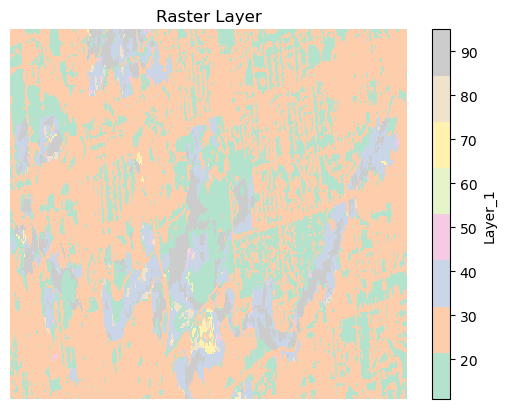

In [11]:
f, ax = plt.subplots()
ou_landcover_2001_ds.plot(ax=ax, cmap='Pastel2')

ax.set(title="Raster Layer")

ax.set_axis_off()
plt.show()


In [12]:
ou_extent_file = Path(Path.cwd(), '../data', 'ou_boundary.gpkg')
ou_extent = gpd.read_file(ou_extent_file)
ou_extent

,geometry
0,"POLYGON ((-83.22051 42.67865, -83.21446 42.678..."


In [13]:
print('crop extent crs: ', ou_extent.crs)
print('nlcd crs: ', ou_landcover_2001_ds.rio.crs)


crop extent crs:  EPSG:4326
nlcd crs:  PROJCS["Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


Need to reproject the polygon file.

In [14]:
crs_aea = ou_landcover_2001_ds.rio.crs
ou_extent_aea = ou_extent.to_crs(crs_aea)
print('crop extent updated crs: ', ou_extent_aea.crs)

crop extent updated crs:  PROJCS["Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


Let's plot both

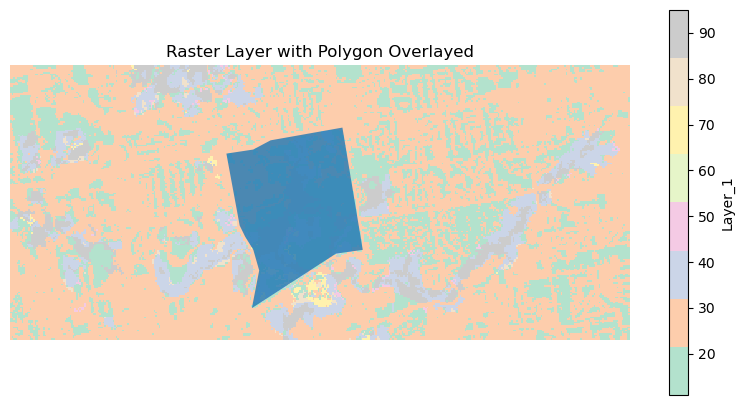

In [15]:
f, ax = plt.subplots(figsize=(10, 5))
ou_landcover_2001_ds.plot(ax=ax, cmap='Pastel2')

ou_extent_aea.plot(ax=ax,
                 alpha=.8)
ax.set(title="Raster Layer with Polygon Overlayed")

ax.set_axis_off()
plt.show()


Now we can clip the raster to the polygon.

- https://corteva.github.io/rioxarray/html/examples/clip_geom.html
- https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/

In [ ]:
ou_extent_aea.geometry.values

In [ ]:
ou_landcover_2001_ds = ou_landcover_2001_ds.rio.clip(ou_extent_aea.geometry.values, drop=True)
ou_landcover_2011_ds = ou_landcover_2011_ds.rio.clip(ou_extent_aea.geometry.values, drop=True)
ou_landcover_2021_ds = ou_landcover_2021_ds.rio.clip(ou_extent_aea.geometry.values, drop=True)

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
ou_landcover_2001_ds.plot(ax=ax, cmap='Pastel2')

ou_extent_aea.plot(ax=ax,
                 alpha=.4)

ax.set(title="Raster Layer with Polygon Overlayed")

ax.set_axis_off()
plt.show()


Do we want to cover exporting the cropped DataArrays to new TIFF files?

In [ ]:
ou_landcover_2001_ds

Explicitly set the nodata attribute for the datasets. Plotting xarrays doesn't honor this and we still need to manually mask using `.where` clause.

In [ ]:
ou_landcover_2001_ds.rio.write_nodata(0, inplace=True)
ou_landcover_2011_ds.rio.write_nodata(0, inplace=True)
ou_landcover_2021_ds.rio.write_nodata(0, inplace=True)

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
ou_landcover_2011_ds.where(ou_landcover_2011_ds > 0).plot(ax=ax, cmap='Pastel2')

ou_extent_aea.plot(ax=ax,
                 alpha=.4)

ax.set(title="Raster Layer with Polygon Overlayed")

ax.set_axis_off()
plt.show()


In [ ]:
ou_landcover_2001_ds.where(ou_landcover_2001_ds > 0)

In [ ]:
#ou_landcover_2001_ds = ou_landcover_2001_ds.where(ou_landcover_2001_ds > 0)
#ou_landcover_2011_ds = ou_landcover_2011_ds.where(ou_landcover_2011_ds > 0)
#ou_landcover_2021_ds = ou_landcover_2021_ds.where(ou_landcover_2021_ds > 0)

```
National Land Cover Database Class Legend and Description
Class\ Value
Classification Description

Water
- 11 Open Water- areas of open water, generally with less than 25% cover of vegetation
or soil.
- 12 Perennial Ice/Snow- areas characterized by a perennial cover of ice and/or snow,
generally greater than 25% of total cover.

Developed
- 21 Developed, Open Space- areas with a mixture of some constructed materials, but
mostly vegetation in the form of lawn grasses. Impervious surfaces account for less
than 20% of total cover. These areas most commonly include large-lot single-family
housing units, parks, golf courses, and vegetation planted in developed settings for
recreation, erosion control, or aesthetic purposes.
- 22 Developed, Low Intensity- areas with a mixture of constructed materials and
vegetation. Impervious surfaces account for 20% to 49% percent of total cover.
These areas most commonly include single-family housing units.
- 23 Developed, Medium Intensity -areas with a mixture of constructed materials and
vegetation. Impervious surfaces account for 50% to 79% of the total cover. These
areas most commonly include single-family housing units.
- 24 Developed High Intensity-highly developed areas where people reside or work in
high numbers. Examples include apartment complexes, row houses and
commercial/industrial. Impervious surfaces account for 80% to 100% of the total
cover.

Barren
- 31 Barren Land (Rock/Sand/Clay) - areas of bedrock, desert pavement, scarps, talus,
slides, volcanic material, glacial debris, sand dunes, strip mines, gravel pits and other
accumulations of earthen material. Generally, vegetation accounts for less than 15%
of total cover.
Forest
- 41 Deciduous Forest- areas dominated by trees generally greater than 5 meters tall,
and greater than 20% of total vegetation cover. More than 75% of the tree species
shed foliage simultaneously in response to seasonal change.
- 42 Evergreen Forest- areas dominated by trees generally greater than 5 meters tall,
and greater than 20% of total vegetation cover. More than 75% of the tree species
maintain their leaves all year. Canopy is never without green foliage.43
Mixed Forest- areas dominated by trees generally greater than 5 meters tall, and
greater than 20% of total vegetation cover. Neither deciduous nor evergreen species
are greater than 75% of total tree cover.

Shrubland
- 51 Dwarf Scrub- Alaska only areas dominated by shrubs less than 20 centimeters tall
with shrub canopy typically greater than 20% of total vegetation. This type is often
co-associated with grasses, sedges, herbs, and non-vascular vegetation.
- 52 Shrub/Scrub- areas dominated by shrubs; less than 5 meters tall with shrub canopy
typically greater than 20% of total vegetation. This class includes true shrubs, young
trees in an early successional stage or trees stunted from environmental conditions.
Herbaceous
- 71 Grassland/Herbaceous- areas dominated by gramanoid or herbaceous vegetation,
generally greater than 80% of total vegetation. These areas are not subject to
intensive management such as tilling, but can be utilized for grazing.
- 72 Sedge/Herbaceous- Alaska only areas dominated by sedges and forbs, generally
greater than 80% of total vegetation. This type can occur with significant other
grasses or other grass like plants, and includes sedge tundra, and sedge tussock
tundra.
- 73 Lichens- Alaska only areas dominated by fruticose or foliose lichens generally
greater than 80% of total vegetation.
- 74 Moss- Alaska only areas dominated by mosses, generally greater than 80% of total
vegetation.

Planted/Cultivated
- 81 Pasture/Hay-areas of grasses, legumes, or grass-legume mixtures planted for
livestock grazing or the production of seed or hay crops, typically on a perennial
cycle. Pasture/hay vegetation accounts for greater than 20% of total vegetation.
- 82 Cultivated Crops -areas used for the production of annual crops, such as corn,
soybeans, vegetables, tobacco, and cotton, and also perennial woody crops such as
orchards and vineyards. Crop vegetation accounts for greater than 20% of total
vegetation. This class also includes all land being actively tilled.

Wetlands
- 90 Woody Wetlands- areas where forest or shrubland vegetation accounts for greater
than 20% of vegetative cover and the soil or substrate is periodically saturated with
or covered with water.
- 95 Emergent Herbaceous Wetlands- Areas where perennial herbaceous vegetation
accounts for greater than 80% of vegetative cover and the soil or substrate is
periodically saturated with or covered with water.
```

In [ ]:
unique_2001, counts_2001 = np.unique(ou_landcover_2001_ds.values, return_counts=True)
print(np.asarray((unique_2001, counts_2001)).T)

In [ ]:
unique_2021, counts_2021 = np.unique(ou_landcover_2021_ds.values, return_counts=True)
print(np.asarray((unique_2021, counts_2021)).T)

In [ ]:
unique_2011, counts_2011 = np.unique(ou_landcover_2011_ds.values, return_counts=True)
print(np.asarray((unique_2011, counts_2011)).T)

The frequency distributions look pretty similar. Faceted histos might be nice way to compare.

First we need to create a dataframe that will facilitate computations with these arrays. We could structure like this:

```
year
group
class
count
```

Maybe easiest to create separate dataframes by year and then stack them.

Should be able to create a `DataFrame` from four arrays.

In [ ]:
# 2001
group_2001 = (unique_2001 / 10).astype('int')
group_2011 = (unique_2011 / 10).astype('int')
group_2021 = (unique_2021 / 10).astype('int')

year_2001 = np.full(len(group_2001), 2001)
year_2011 = np.full(len(group_2011), 2011)
year_2021 = np.full(len(group_2021), 2021)


land_cover_2001_df = pd.DataFrame({'year': year_2001, 'group': group_2001, 'class': unique_2001, 'count':counts_2001})
land_cover_2011_df = pd.DataFrame({'year': year_2011, 'group': group_2011, 'class': unique_2011, 'count':counts_2011})
land_cover_2021_df = pd.DataFrame({'year': year_2021, 'group': group_2021, 'class': unique_2021, 'count':counts_2021})

land_cover_df = pd.concat([land_cover_2001_df, land_cover_2011_df, land_cover_2021_df])
# Filter out the zeros (nodata)
land_cover_df = land_cover_df[land_cover_df['group'] > 0]
land_cover_df

Compute percentage of pixels in class 2 by year.

In [ ]:
group_counts = land_cover_df.groupby(['year', 'group'])['count'].sum()
print(group_counts)

In [ ]:
group_counts.groupby(['year']).transform('sum')

In [ ]:
group_counts / group_counts.groupby(['year']).transform('sum')

In [ ]:
land_cover_df.groupby(['year', 'group'])['count'].transform('sum')

In [ ]:
land_cover_df['count'] / land_cover_df.groupby(['year', 'group'])['count'].transform('sum')

In [ ]:
land_cover_df['pct_of_group'] = land_cover_df['count'] / land_cover_df.groupby(['year', 'group'])['count'].transform('sum')

In [ ]:
land_cover_df

Overall, the amount of developed land has remained steady over the past 20 years. Let's look at the more detailed change in the type of developed land - 21 (open space), 22 (low intensity), 23 (medium intensity), 24 (high intensity). Then let's also look at the change in forested land (41 and 42) as well as forested wetlands (90).

First, let's use [Series.unstack](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.unstack.html) to convert this `Series` and its multiindex into a `DataFrame`.

- turns out this doesn't work as there appears to be a bug with multiindex unstacking or you just can't unstack all levels
- one option might be to unstack by one level and then melt
- another option is to use `reset_index` and don't drop the columns

In [ ]:
group_pct_mix = group_counts / group_counts.groupby(['year']).transform('sum')
group_pct_mix_df = group_pct_mix.reset_index(drop=False)
group_pct_mix_df = group_pct_mix_df.rename({'count': 'pct'}, axis=1)
group_pct_mix_df

Let's plot the change in group 2 (developed).

In [ ]:
import seaborn as sns

In [ ]:
sns.lineplot(group_pct_mix_df[group_pct_mix_df['group'] == 2], x='year', y='pct')

In [ ]:
group_pct_mix_df[group_pct_mix_df['group'] == 2]

In [ ]:
group_pct_mix_df[group_pct_mix_df['group'] == 4]

In [ ]:
group_pct_mix_df[group_pct_mix_df['group'] == 9]

In [ ]:
land_cover_df[land_cover_df['class'] == 21]

In [ ]:
land_cover_df[land_cover_df['class'] == 22]

In [ ]:
land_cover_df[land_cover_df['class'] == 23]

In [ ]:
land_cover_df[land_cover_df['class'] == 24]

What about the change file? ou_change_index_2002_2021.tif

https://www.mrlc.gov/data/nlcd-land-cover-change-index-conus

https://gis.stackexchange.com/questions/350212/national-land-cover-dataset-2016-land-cover-change-index-values-meaning

The answer given in the above link quotes this "from the metadata" but I can't find it.

> 

    The NLCD 2016 Land Cover Change Index is a raster image with an accompanying look-up table that describes the land cover change represented by each index. Previous releases of NLCD land cover covered one target year, and a land cover change index was compiled of change from every class in the previous target year to every class in the current one – for example from 2006 to 2011 or from 2001 to 2006.

    NLCD 2016 Land Cover spans not one but seven target years: 2001, 2003, 2006, 2008, 2011, 2013, and 2016. Rather than compiling six land cover change index products (one for each pair of adjacent target years), there is a single NLCD 2016 Land Cover Change Index product whose pixel values indicate land cover changes that occurred at least once between 2001 and 2016. Each assigned image value represents either “No Change” (Index number 1) or one of the changes described below.

    Index number 2 identifies pixels that have changed from any land cover class to Water, or from Water to any other land cover class, between any two adjacent target years. Indices 5, 7, 8, 10, and 21 are similar identifiers of change from or to a single land cover class.

    Index 3 identifies changes from any land cover class to any of the four Urban land cover classes, or from any of those four classes to any other land cover class, between any two adjacent target years. Index 11 similarly identifies changes from or to any of the three Forest classes.

    Index 4 narrowly identifies changes only between Herbaceous Wetland and Woody Wetland. Similarly, Index 6 identifies changes only between Cultivated Crops and Hay / Pasture.

    Index 9 meets a special requirement of shrubland research to discriminate where change occurs on persistent shrublands verses change on transitional shrubland areas such as regenerating forests.

    Pixel /Index Value Description 
    
    - 1 No Change 
    - 2 Change from or to Water 
    - 3 Change from or to any of the four Urban classes (open space; low, medium, and high intensity) 
    - 4 Change from Herbaceous Wetland to Woody Wetland, or vice versa 
    - 5 Change from or to Herbaceous Wetland 
    - 6 Change from Cultivated Crops to Hay / Pasture, or vice versa 
    - 7 Change from or to Cultivated Crops 
    - 8 Change from or to Hay / Pasture 
    - 9 Persistent Grassland and Shrubland change. This change index attempts to identify changes to persistent Grassland and Shrubland areas, and to separate them from transitional shrubland areas such as regenerating forests. 
    - 10 Change from or to Barren 
    - 11 Change from or to any of the three Forest classes (Evergreen, Deciduous, and Mixed) 
    - 12 Change from or to Woody Wetland

    Identifying the specific changes from one target year’s land cover class to another, and the specific target years when the changes occurred, both require analysis of the land cover data itself.




In [ ]:
ou_change_index_2002_2021_ds = rioxarray.open_rasterio(Path(Path.cwd(), 'data', 'ou_change_index_2002_2021.tif'))
ou_change_index_2002_2021_ds = ou_change_index_2002_2021_ds.rio.clip(ou_extent_aea.geometry.values, drop=True)
ou_change_index_2002_2021_ds

In [ ]:
ou_change_index_2002_2021_ds.values

In [ ]:
unique_change_index, counts_change_index = np.unique(ou_change_index_2002_2021_ds.values, return_counts=True)
print(np.asarray((unique_change_index, counts_change_index)).T)

See metadata above for interpretation.

## Extracting vector data from OSM using QGIS

https://www.youtube.com/watch?v=Yxkh2f-3Bj8

Video covers using OSM as a base map in QGIS and then querying features (e.g. building) to download and create vector layer of those features. 

## Rivers on campus

Can use Hydrosheds to plot rivers. Um, no. See result. :) Need more detailed data. Looks like State of Michigan has publicly available GIS data from https://gis-michigan.opendata.arcgis.com/. It's got tons of data!

There is a [Hydrography Lines](https://gis-michigan.opendata.arcgis.com/datasets/f34a4c83afea4736a003e9f92bb0c6c8_2/explore?location=42.665119%2C-83.197162%2C14.32) dataset that can be downloaded in CSV, KML, Shapefile or GeoJSON format. I did GeoJSON.



In [ ]:
import os
WSFR_DATA_ROOT = os.environ['WSFR_DATA_ROOT']

In [ ]:
rivers_file = Path(WSFR_DATA_ROOT,'hydrosheds/HydroRIVERS_v10_na.gdb/HydroRIVERS_v10_na.gdb')
rivers_gdf = gpd.read_file(rivers_file, engine='pyogrio')
rivers_gdf = rivers_gdf.to_crs(crs_aea)
rivers_gdf.info()

In [ ]:
rivers_file_MI = Path(Path.cwd(), 'data', 'Hydrography_Lines_(v17a).geojson')
rivers_MI_gdf = gpd.read_file(rivers_file_MI, engine='pyogrio')
rivers_MI_gdf = rivers_MI_gdf.to_crs(crs_aea)
rivers_MI_gdf.info()

In [ ]:
rivers_MI_gdf.crs

In [ ]:
rivers_MI_gdf

In [ ]:
rivers_gdf.iloc[0:3]['geometry']

How to find those river segments that intersect the OU polygon?

In [ ]:
ou_extent_aea_polygon = ou_extent_aea.iloc[0].iloc[0]

In [ ]:
print(ou_extent_aea_polygon)

https://stackoverflow.com/questions/20474549/extract-points-coordinates-from-a-polygon-in-shapely

In [ ]:
import shapely

In [ ]:
shapely.get_coordinates(ou_extent_aea_polygon)

In [ ]:
tuple(ou_extent_aea_polygon.exterior.coords)

In [ ]:
xx, yy = ou_extent_aea_polygon.exterior.coords.xy
print(xx)
print(yy)

In [ ]:
minx_poly = min(xx)
maxx_poly = max(xx)
miny_poly = min(yy)
maxy_poly = max(yy)


In [ ]:
sum(rivers_gdf.intersects(ou_extent_aea_polygon))

In [ ]:
rivers_ou_gdf = rivers_gdf[rivers_gdf.intersects(ou_extent_aea_polygon)]


rivers_ou_MI_gdf = rivers_MI_gdf[rivers_MI_gdf.intersects(ou_extent_aea_polygon)]

In [ ]:
rivers_MI_gdf[rivers_MI_gdf.intersects(ou_extent_aea_polygon)]

In [ ]:
rivers_ou_gdf

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
ou_landcover_2011_ds.where(ou_landcover_2011_ds > 0).plot(ax=ax, cmap='Pastel2')

rivers_MI_gdf.plot(ax=ax)

ax.set(title="Raster Layer with River")

ax.set_axis_off()
plt.show()


In [ ]:
f, ax = plt.subplots(figsize=(10, 5))

ou_landcover_2011_ds.where(ou_landcover_2011_ds > 0).plot(ax=ax, cmap='Pastel2')

rivers_ou_gdf.plot(ax=ax)


ax.set(title="Raster Layer with River")

ax.set_axis_off()
plt.show()


In [ ]:
import cartopy.crs as ccrs                   # import projections

In [ ]:
crs_aea = ccrs.AlbersEqualArea(central_longitude=-96,
                               central_latitude=40,
                               standard_parallels=(20.0, 60.0))

In [ ]:
cartopy_extent_aea = (minx_poly, maxx_poly, miny_poly, maxy_poly)

In [ ]:
print(cartopy_extent_aea)

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))

# create a set of axes with desired projection  
ax = plt.axes(projection = crs_aea)

# Set map extent
ax.set_extent(cartopy_extent_aea, crs = crs_aea)

ou_landcover_2011_ds.where(ou_landcover_2011_ds > 0).plot(ax=ax, cmap='Pastel2')

rivers_MI_gdf.plot(ax=ax)

ax.set(title="Raster Layer with River")

ax.set_axis_off()
plt.show()


Hmmm, not sure how to not plot rivers outside polygon. Feels like I need to clip the rivers:

https://gis.stackexchange.com/questions/340058/geopandas-cut-lines-with-polygon

In [ ]:
intersection = rivers_MI_gdf.intersection(ou_extent_aea_polygon)

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))

# create a set of axes with desired projection  
ax = plt.axes(projection = crs_aea)

# Set map extent
ax.set_extent(cartopy_extent_aea, crs = crs_aea)

ou_landcover_2011_ds.where(ou_landcover_2011_ds > 0).plot(ax=ax, cmap='Pastel2')

intersection.plot(ax=ax)

ax.set(title="Raster Layer with River")

ax.set_axis_off()
plt.show()


**NOTE**

There's some trickiness with the CRS in GeoJSON files. Note that the coordinates are in long/lat order. See

- https://github.com/CityScope/CS_choiceModels/issues/4
- https://github.com/OSGeo/gdal/issues/2035

Once we read it into GeoPandas, the CRS gets assigned as EPSG:4326.

From https://rgdal.r-forge.r-project.org/articles/CRS_projections_transformations.html (R Bivend)

> It will be useful to know that in general "OGC:CRS84" should be used instead of "EPSG:4326", because the latter presupposes that Latitude is always ordered before Longitude. "OGC:CRS84" is the standard representation used by GeoJSON, with coordinates always ordered Longitude before Latitude. 